# Table of Contents
1. Exploration
2. Evaluation in the context of bias and constraints
3. Result volumes and selecting an evaluation measure
4. Baseline
5. Feature engineering
6. Holdout evaluation
7. New Listings: UX, dispersion, and ML scoring

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from haversine import haversine
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


I'll begin by loading the data and splitting off an initial subset of the data to inspect to build intuition around and a framework for the assignment's approach. 

In [2]:
df_all = pd.read_csv('data/takehome_data.tsv', sep='\t', low_memory=False)

In [3]:
df_all.ds_search.value_counts().sort_index()

11/20/18    25608
11/21/18    27548
11/22/18    28374
11/23/18    27344
11/25/18    29007
11/26/18    39707
Name: ds_search, dtype: int64

In the next section I'll call out the impact of evaluating user searches vs user experiences. But given the abscence of data on 11/24/18 I'll break apart the dataset into searches executed before 11/24/18 as the training dataset, searches on 11/25/18 as an evaluation set, and 11/26/18 as a final hold out set

In [4]:
sorted(df_all.ds_search.unique()) # no nulls

['11/20/18', '11/21/18', '11/22/18', '11/23/18', '11/25/18', '11/26/18']

In [5]:
df_all['ts_search'] = pd.to_datetime(df_all.ts_search).astype(int)

In [6]:
# unique users and listing count in training set 
df = df_all.loc[df_all.ds_search.isin(['11/20/18', '11/21/18', '11/22/18', '11/23/18'])]
pd.Series([len(df.id_user.unique()), len(df.id_listing.unique())], index=['users','listings']).to_frame().T

,users,listings
0,2271,25928


In [7]:
validation_df = df_all.loc[df_all.ds_search.isin(['11/25/18'])]
holdout_df = df_all.loc[df_all.ds_search.isin(['11/26/18'])]

In [8]:
assert len(df_all) == sum(len(i) for i in [df, validation_df, holdout_df])

In [9]:
df.shape

(108874, 49)

In [10]:
counts = df.groupby('label').id_search.count().loc[['book', 'host_contact', 'click', 'impression']].rename('records')
cumulative = counts.cumsum().sort_values(ascending=False).rename('cumulative_counts')
funnel = pd.concat([counts, cumulative], axis=1, sort=False).sort_values('cumulative_counts', ascending=False)
funnel['percent'] = (funnel.cumulative_counts.astype(float) / funnel.loc['impression', 'cumulative_counts'] * 100).round(1)
funnel

,records,cumulative_counts,percent
impression,81164,108874,100.0
click,24727,27710,25.5
host_contact,1683,2983,2.7
book,1300,1300,1.2


Note: this is funnel - cumalitive numbers imply made it to this step or farther down funnel

## Evaluation in the context of bias, caveats, known issues, and time-constraints

The time to solve this problem ( ~1 work day) as well as data availabilty and inherent bias of the dataset are all considerations for the proposed approach. I wil try to combat some of these, call out others, and when possible attempt to leverage the constraint to optimize the system. 

#### Introduction & post-hoc bias. 
The data available is defined by the user's interaction with AirBnB's existing search infrastructure. If AirBnB's existing infra pushes a listing farther down the queue the user is less likley to receive it as an impression, which prevents that listing from being booked. Because some of the data detailing the availability of a listing is not accessable, such as for the given date range requested "what listings are available", I will take an approach to optimize for the information we have and discuss how it could be integrated to existing systems noting this bias.  

#### Optimization & user sessions + redundant searches. 
Having a strong dialogue with relevant stakeholders to better understand the objectives is a critical part of integrating machine learning products to optimize for business impact. Here I see an additional layer of importance due to the interactions with existing infra. The first issue is called out above, but the second is with respect to the primary key / atomic unit by which we evaluate the model. A user can only book one listing per day. In order to make that booking a user will often execute multiple searches, possibly in quick succession and/or over the course of longer time periods. 

If the ultimate goal is to optimize for the booking rate per search this is subtley different from the goal to optimize for the number of a user's booked trips and/or the number of days a user spends staying at AirBnB accommodations. Each of those frames modify the manner in which search requests can be pooled, represented as coelesce searches into windows to quantifably evaluate the models relationship to the user. 

I will build a system to augment the existing search infrastructure, by ranking the results of the impressions served by the search engine within a window that skews but does not entirely concede towards bias removal at a cost of data density (more on that two sections below). Work in this area would be critical to the improvement of this model in the future. 

Note - I recognize that to serve listings an initial score is needed to yield impressions and this is not that score.

### Ranking evaluation within the context of "impressed" listings
This system will be a ranking system to order listings based on how likely a user is to book the listing given the metadata supplied in the search query with discussion and future addressment of other business goals and impacts. This ordering assumes existing infrastructure enforces hard rules - such as listing availability, price bounds, guest capacity and other hard requirements - are already enforced and this system will decide how to order those results - "impressions" - for the user.

#### KPI: NDCG of uniquely defined queries on a given day
Normalized discounted cumlative gain of the "served" listing will help us understand how our model is ranking the available listings. NDCG enables leveraging the ordinal importance of available user interactions 
(click, host contact, booking) assuming an impression has been made. To evaluate the effectiveness of a given model, the test set will be subset down to searches that have at least one interaction event, because the gain of homogenous collections will not vary across models.  

Due to a lack of integration with the existing search engine, I call out that this implementation suffers from not surfacing the most optimal listings across AirBnB's catalog. Optimizing the likelihood of generating an impression is critical for the end to end success of the search engine. The given dataset could potentially support work in this area, however those estimates will be substantially obfuscated from the lack of other data, such as listing availability for the requested date range, user session metadata, listing per page, and the units of the query_radius among others. That model would be attempting to learn the outputs of an existing system with obfuscated data rather than an attempting to impact a user behavior. 

This product will focus on evaluating the user impressions via pooling uniquely defined user queries on a given day. This metric is imperfect but will yield a larger pool than only search_id pooling and shades closer to the user's experience. This metric is muddied by the fact that despite the same query by the same user on the same day, new listings could come on the market or reopen and others could come off. Without access to that data, and the width of date ranges queried, the changes in market conditions will be offset by giving a larger and likely richer collection of listings to evaluate in a given pool. Pool size could be increased by removing the uniquely defined criteria, however removing certain requirements that are interpreted as hard rules (such as price floor / ceiling) would then require an additional filtering step, yielding both additional engineering resources to filter the recommendations before serving in addition to generating bias in the evaluation metric.  

#### Caveat

NDCG and other similar metrics such as MAP assume monotonic decrease of the relative difference between subsequent ranks. Implied in this definition is that users effectively perceive this return as a steady stream. However, listings are returned in batch (i.e. pages to leaf through or mini batch like rows). The activation energy to go from page 1 to page 2 or the next row off the screen is quite impactful to a user's response and is not captured in this metric. This is an area to address with future improvements.


In [11]:
# based on https://gist.github.com/mblondel/7337391. Tests explicitly ripped from gist at bottom of notebook
import numpy as np

def dcg(y_true, y_predicted, gain=lambda x: (2** x - 1)):
    gained = gain(y_true[np.argsort(-np.asarray(y_predicted))])
    discounted = np.log2(np.arange(2, len(y_true) + 2))
    return np.sum(gained / discounted)
                        
def ndcg(y_true, y_predicted, gain=lambda x: (2** x - 1)):
    max_score = dcg(y_true, y_true, gain=gain)
    actual_score = dcg(y_true, y_predicted, gain=gain)
    return actual_score / max_score                      

### Result volume
The number of listings returned will help inform our evaluation criteria. We can see the impact on increasing the pooling volume by loosening uniqueness restrictions and ultimately settle on mini-max esque approach that skews towards removing bias

#### Key by search_id (most restrictive)

In [12]:
search_id = df.groupby(['id_search']).id_user.count().sort_values(ascending=False)\
.to_frame().rename(columns={'id_user': 'impressions_returned'})
search_id.describe()

,impressions_returned
count,38325.000000
mean,2.840809
std,2.232785
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,18.000000


Text(0,0.5,'number of pools')

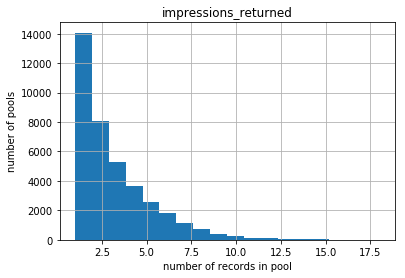

In [13]:
search_id.hist(bins=18)
plt.xlabel('number of records in pool')
plt.ylabel('number of pools')

#### Key by user, date range, and market (least restrictive within reason)

Without more user event data it's challenging to correctly coelesce searches. Searches in the same market with overlapping date ranges is one approach with the given data, however there's nuance to that approach as a cause of this can be user's considering staying at multiple locations either due to location, cost, number of guests, and availability as well as how those features interact with the listings considerations #TwoSidedMarketplace

As a rough initial cut, given a user can only book in one place, aggregating by date range and user helps coelesce some of our searches while trying to mitigate bias. As we can see in the table below, for user `0077431ca40d7d0c028247ecb1da9874`, the first record and fourth record are more likely independent (although the user could have flexibility with the trip date), while the second or third requests are likely strongly anti-correlated with respect to each other as a condition on booking. 

While the volume generated by this approach is appealing, the additional technical overhead of filtering responses and increased bias aren't justifiable at this point. This work does support the potential value add of future work in the space

In [14]:
search_window = df.groupby(['id_user', 'query_checkin', 'query_checkout', 'query_market']).id_search.count()\
    .to_frame().rename(columns={'id_search': 'impressions_returned'})

search_window.head(10)

impressions_returned
id_user                          query_checkin query_checkout query_market                        
00226cf02c6c8907b096d0637bc84b29 12/7/18       12/9/18        Sao Paulo                         26
0077431ca40d7d0c028247ecb1da9874 1/9/19        1/13/19        Rio de Janeiro                     4
                                 2/27/19       3/6/19         Rio de Janeiro                    48
                                               3/7/19         Rio de Janeiro                    42
                                 3/13/19       3/14/19        Rio de Janeiro                     4
0088b42325fa2906faf06cb7bfcef953 12/19/18      12/25/18       Rio de Janeiro                     9
                                               12/26/18       Rio de Janeiro                     2
0092c34fa07040ccec7411af56e7ad2a 12/15/18      12/20/18       Rio de Janeiro                    16
009b1efd29ceb1277b8e503497a7560b 1/11/19       1/12/19        Sao Paulo                          1
                                               1/15/19        Sao Paulo                         44

Text(0,0.5,'number of pools')

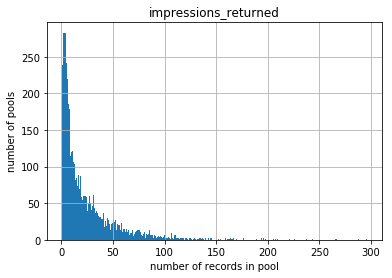

In [15]:
search_window.hist(bins=search_window.impressions_returned.max())
plt.xlabel('number of records in pool')
plt.ylabel('number of pools')

#### Key by user, full query parameters, and date of search.
We'll consider a unique query by it's attributes and the date of the search. (Again a call out to future pooling work). The search date criteria is included because our test and evaluation data sets are single days each (noting one has 25% more records than the other) so we use this as an attempt to build intuition around the expected size of a pool in our validation set. 

In [16]:
search_window_full_query = df.groupby([i for i in df if (i in ['ds_search', 'id_user'] 
                                                         or i.startswith('query'))]).id_search.count()\
    .to_frame().rename(columns={'id_search': 'impressions_returned'})

search_window_full_query.head(15)

impressions_returned
id_user                          ds_search query_market   query_checkin query_checkout query_num_guests query_num_children query_num_infants query_radius query_price_max query_price_min query_center_lat query_center_lng                      
00226cf02c6c8907b096d0637bc84b29 11/21/18  Sao Paulo      12/7/18       12/9/18        2                0                  0                 2.861446      1.070000e+09    50             -23.59           -46.66                               1
                                                                                                                                             2.861502     -1.000000e+00   -1              -23.58           -46.64                               4
                                                                                                                                             2.861563      1.070000e+09    50             -23.58           -46.66                               1
                                                                                                                                             2.861606      1.070000e+09    50             -23.58           -46.65                               4
                                                                                                                                             2.861710      1.070000e+09    50             -23.58           -46.66                               1
                                                                                                                                             2.862022     -1.000000e+00   -1              -23.56           -46.65                               2
                                                                                                                                             2.862101     -1.000000e+00   -1              -23.56           -46.65                               6
                                                                                                                                             2.862210     -1.000000e+00   -1              -23.55           -46.66                               1
                                                                                                                                             5.722837     -1.000000e+00   -1              -23.59           -46.63                               1
                                                                                                                                             5.723167      1.070000e+09    50             -23.58           -46.65                               2
                                                                                                                                             5.723401     -1.000000e+00   -1              -23.58           -46.64                               1
                                                                                                                                             5.723618     -1.000000e+00   -1              -23.57           -46.64                               2
0077431ca40d7d0c028247ecb1da9874 11/20/18  Rio de Janeiro 2/27/19       3/7/19         2                0                  0                 1.318039     -1.000000e+00   -1              -22.97           -43.19                               7
                                                                                                                                                           5.760000e+02    0              -22.97           -43.19                               2
                                                                                                                                                           8.730000e+02    0              -22.97           -43.19                               2

Text(0,0.5,'number of pools')

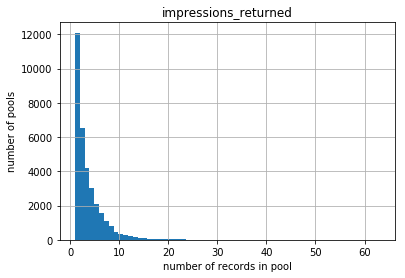

In [17]:
search_window_full_query.hist(bins=search_window_full_query.impressions_returned.max())
plt.xlabel('number of records in pool')
plt.ylabel('number of pools')

#### Impact of key parameterization
By moving from the most restrictive to a slightly less restrictive pooling we gain an averge of 15% in pool size, 
noting the lift in gain follows the skew of the volume. Future work in number of searches correlating with likelihood of booking is another interesting area to explore.

In [18]:
description = pd.concat([i.describe(percentiles=pd.np.linspace(.2,.8,4)) for i in
                         [search_id, search_window, search_window_full_query]], axis=1)
description.columns = ['search_id', 'search_window', 'search_window_full_query']
description

,search_id,search_window,search_window_full_query
count,38325.000000,4542.000000,33318.000000
mean,2.840809,23.970498,3.267723
std,2.232785,29.156640,3.295503
min,1.000000,1.000000,1.000000
20%,1.000000,4.000000,1.000000
40%,2.000000,9.000000,2.000000
50%,2.000000,13.000000,2.000000
60.0%,3.000000,19.000000,3.000000
80%,4.000000,38.800000,5.000000
max,18.000000,296.000000,63.000000


####  Number of searches per user per day
There is a lot to explore in user search interactions. I'll curtail that discussion to allow for more time on the system itself with a last look at user searches per day as support for query parameter based pooling over pooling by search_id only. Here we see a stable search count per user per day

In [19]:
user_searches = df[['id_search', 'id_user', 'ds_search']].drop_duplicates().groupby(['id_user', 'ds_search'])\
.id_search.count().to_frame().rename(columns={'id_search': 'searches_per_user'}).reset_index().groupby('ds_search')\
.searches_per_user

user_searches.describe()

,count,mean,std,min,25%,50%,75%,max
ds_search,,,,,,,,
11/20/18,869.0,10.698504,11.633468,1.0,3.0,7.0,14.0,94.0
11/21/18,965.0,10.222798,10.957344,1.0,3.0,7.0,14.0,101.0
11/22/18,958.0,10.515658,11.095447,1.0,3.0,7.0,14.0,79.0
11/23/18,927.0,9.804746,9.719703,1.0,3.0,7.0,14.0,75.0


ds_search
11/20/18    AxesSubplot(0.125,0.125;0.775x0.755)
11/21/18    AxesSubplot(0.125,0.125;0.775x0.755)
11/22/18    AxesSubplot(0.125,0.125;0.775x0.755)
11/23/18    AxesSubplot(0.125,0.125;0.775x0.755)
Name: searches_per_user, dtype: object

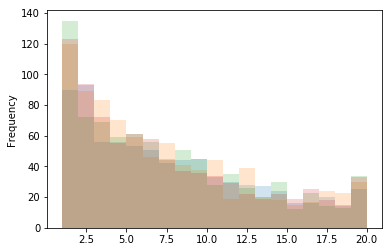

In [20]:
user_searches.plot.hist(bins=range(1, 21), histtype='bar', alpha=.2)

## Modeling
#### Baseline
In this section I'll begin with a raw inspection of fields to make sure that a baseline model is not suffering from any leakage and evaluate before moving on to more in depth data inspection and feature engineering

In [21]:
df.head(3)

,id_search,label,id_user,id_listing,ts_search,ds_search,ds_book,ds_contact,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_instant_bookable,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_room_type,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_has_pro_pictures,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
25,c197cac4-4d3e-4644-837d-b8664bcf9a35,impression,f9d0b13bfe4dc6a76862b4884f1c08e6,350f0b56db405ba2bd6625ee27ed93bb,1542981540000000000,11/23/18,NaN,NaN,Sao Paulo,11/27/18,11/30/18,1,0,0,0.860144,-1.0,-1,-23.59,-46.68,1,300.00000,False,-23.58,-46.67,0.000000,0.0,1.0,Private Room,1.0,1.0,1,2,NaN,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0,0.000000,0,0,NaN,NaN,NaN,1.0,1125.0
26,073080bb-8453-4c62-b679-8c48dd070dec,click,f9d0b13bfe4dc6a76862b4884f1c08e6,19cacd588e89c13d513ed7771484d43e,1542840540000000000,11/21/18,NaN,NaN,Sao Paulo,11/28/18,11/30/18,1,0,0,0.479950,220.0,0,-23.59,-46.68,0,143.71162,False,-23.59,-46.68,4.000000,3.0,47.0,Entire Home,3.0,2.0,1,4,False,0,5.000000,4.000000,5.000000,4.333334,5.000000,5.000000,1.0,NaN,0,0,39.919950,NaN,NaN,2.0,1125.0
27,f83903b1-7b0f-4234-b516-b4b15f3f57e9,book,f9d0b13bfe4dc6a76862b4884f1c08e6,714dcf2e4f64324b4a48942ca3f14745,1542983340000000000,11/23/18,11/23/18,11/23/18,Sao Paulo,11/27/18,11/30/18,1,0,0,0.729681,140.0,0,-23.59,-46.68,0,201.31122,False,-23.58,-46.67,4.666666,18.0,47.0,Entire Home,2.0,1.0,NaN,3,NaN,0,4.944445,4.944445,4.888889,4.500000,4.888889,4.777778,22.0,0.727273,1,1,13.149002,0.8,0.95,1.0,89.0


In [22]:
df.dtypes.to_frame().T

,id_search,label,id_user,id_listing,ts_search,ds_search,ds_book,ds_contact,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_instant_bookable,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_room_type,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_has_pro_pictures,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
0,object,object,object,object,int64,object,object,object,object,object,object,int64,int64,int64,float64,float64,int64,float64,float64,int64,float64,bool,float64,float64,float64,float64,float64,object,float64,float64,object,int64,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,object,float64,float64,float64


#### Recasting
A few fields need to be recast, this is most likely incorrect type inference in pandas' reader in combination with None / Null values that do not register as NaN

1. listing_num_bathrooms
2. listing_monthly_price_factor

Note - listing_has_pro_pictures - technically bool - we can either convert None to False or treat it as a third category

In [23]:
def safe_float(i):
    try:
        return float(i)
    except ValueError:
        return pd.np.nan
    
for i in [df, validation_df, holdout_df]:
    columns = ['listing_num_bathrooms', 'listing_monthly_price_factor']
    print(i[columns].isnull().mean())
    for column in columns:
        i[column] = i[column].apply(safe_float)
    print(i[columns].isnull().mean())
    print(i[columns].dtypes)
    print('*'* 10)
    
    # convert to timestamps
    i['query_checkout'] = pd.to_datetime(i.query_checkout)
    i['query_checkin'] = pd.to_datetime(i.query_checkin)

listing_num_bathrooms           0.051849
listing_monthly_price_factor    0.264948
dtype: float64
listing_num_bathrooms           0.051849
listing_monthly_price_factor    0.264948
dtype: float64
listing_num_bathrooms           float64
listing_monthly_price_factor    float64
dtype: object
**********
listing_num_bathrooms           0.050712
listing_monthly_price_factor    0.254421
dtype: float64
listing_num_bathrooms           0.050746
listing_monthly_price_factor    0.254456
dtype: float64
listing_num_bathrooms           float64
listing_monthly_price_factor    float64
dtype: object
**********
listing_num_bathrooms           0.050999
listing_monthly_price_factor    0.262019
dtype: float64
listing_num_bathrooms           0.050999
listing_monthly_price_factor    0.262019
dtype: float64
listing_num_bathrooms           float64
listing_monthly_price_factor    float64
dtype: object
**********


In [24]:
numeric = df.select_dtypes(pd.np.number)
numeric.head(3)

,ts_search,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
25,1542981540000000000,1,0,0,0.860144,-1.0,-1,-23.59,-46.68,1,300.00000,-23.58,-46.67,0.000000,0.0,1.0,1.0,1.0,1.0,2,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0,0.000000,0,0,NaN,NaN,NaN,1.0,1125.0
26,1542840540000000000,1,0,0,0.479950,220.0,0,-23.59,-46.68,0,143.71162,-23.59,-46.68,4.000000,3.0,47.0,3.0,2.0,1.0,4,0,5.000000,4.000000,5.000000,4.333334,5.000000,5.000000,1.0,NaN,0,0,39.919950,NaN,NaN,2.0,1125.0
27,1542983340000000000,1,0,0,0.729681,140.0,0,-23.59,-46.68,0,201.31122,-23.58,-46.67,4.666666,18.0,47.0,2.0,1.0,NaN,3,0,4.944445,4.944445,4.888889,4.500000,4.888889,4.777778,22.0,0.727273,1,1,13.149002,0.8,0.95,1.0,89.0


Treatments for nulls is a critical component of model development, but to close the loop for a first baseline glm
I'll impute the mean. Subsequent work on mean vs specific value filling vs other treatments to come in subsequent steps. 

#### Donatello
Donatello is a personal project of mine. It's still in development, but for currently supported use cases it can be a  helpful tool for building and evaluating the scoring components of ML systems. Here I'll use it to a build scorer for the likelihood of a given impression converting to a booking. Some of it's advantages include traceability and reproducibility, a transformation graph, and terse access to a variety of cross validation and metric evaluation strategies. Some of it's disadvantages include runtime speeds (parallelization is not fully supported yet) which can couple with unintentionally building lots of models (due to nesting grid search folds within cross val folds for metric estimates if those flags are activated), and weak (but growing!) test coverage. Given more time or with existing infrastructue I'd certainly make strong considerations for using other tools or building more from scratch. 

NOTE: If it'd be helpful for interview-evaluation purposes to see any of the model development code built out from scratch, just let me know and I'd be happy to, thanks!

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

from donatello.components import core, data, estimator, transformers, measure
from donatello.utils import helpers

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


def load_model(model=LogisticRegression()):

    graph = transformers.ModelDAG(set([]), {}, graphKwargs={'name': 'airbnb_recommendation'})
    
    n1 = transformers.Node('select', transformer=transformers.DatasetFlow(selectValue={'include': [pd.np.number]},
                                                                          selectMethod='data_type'))
    
    n2 = transformers.Node('impute', transformer=transformers.Imputer(), enforceTarget=True)
    n3 = transformers.Node('scale', transformer=transformers.StandardScaler(), enforceTarget=True)
    
    n4 = transformers.Node('ml', transformer=model)

    graph.add_edge_flow(n1, n2)
    graph.add_edge_flow(n2, n3)
    graph.add_edge_flow(n3, n4)

    return graph


def load_sculpture(df,
                   outsideDf=None,
                   model=load_model(), 
                   paramGrid={'model__ml__C': list(pd.np.logspace(-3, 1, 5))},
                   searchKwargs={'scoring': 'roc_auc', 'cv': 3, 'n_jobs': -1},
                   weights='coefficients',
                   validation=None,
                   holdout=None,
                   entire='search'                   
                  ):
    """
    Helper function to load core modeling object
    
    validation, holdout, and entire can be passed a bool for as to whether to run the block,
    or the string 'search' to run it with grid searching on (if a paramGrid is passed as well)
    Args:
        df (pd.DataFrame): Full training dataset
        outsideData (pd.DataFrame): a hold out set only for evaluation purposes
        model (sklearn.BaseEstimator): uphold sklearn contracts of base + fit / predict(_proba) decision_function
        paramGrid (dict): optional - configuration of parameter grid to search for hyperparameter tuning
        searchKwargs(dict): optional - configuration for sklearn.model_selection.gridSearchCV
        validation (bool|str): option to execute nested cross validation block and whether to tune inside
        validation (bool|str): option to fit on entier passed in dataset
        holdout (bool|str): option to fit excute internal split on train and evaluation on test
        entire (bool|str): option to fit on the entire passed in dataset\
            (assumes a heldout exists elsewhere or is integrated via outsideData)


    """
    df = df.copy()
    df['is_booked'] = df['label'] == 'book'

    # partition over user_ids -> all searches associated with given user will be in same subset
    # within cross val measurements (and within the sub cross validation parameter tuning folds if applicable)
    dataset = data.Dataset(raw=df, target='is_booked', clay='group', groupDap={'attrPath': ['id_user']})

    est = estimator.Estimator(model=model,
                              paramGrid=paramGrid,
                              searchKwargs=searchKwargs,
                              method='predict_proba',
                              scorer='score_second'
                              )

    # Produce scalar and vector binary classification metrics on test set (heldout) data
    metrics = [measure.Metric(roc_auc_score), measure.Metric(average_precision_score),
               measure.FeatureWeights(sort=weights), measure.ThresholdRates()]

    if outsideDf is not None:
        outsideDf = outsideDf.copy()
        outsideDf['is_booked'] = outsideDf['label'] == 'book'

        outsideData = data.Dataset(raw=outsideDf, target='is_booked')
    else:
        outsideData = None
        
    sculpture = core.Sculpture(dataset=dataset, estimator=est, metrics=metrics,
                               validation=validation, holdout=holdout, entire=entire,
                               outsideData=outsideData)

    return sculpture

    

In [26]:
s = load_sculpture(df, outsideDf=validation_df, 
                   model=load_model(), 
                   validation='search', holdout=None, entire='search')

In [27]:
s.fit()
# stdout prints what dataset is being fit and whether
# or not a grid search is being executed on (the/a subset of) data

Cross Validation
grid searching


//anaconda/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


grid searching
grid searching
grid searching
grid searching
Entire Dataset
grid searching


Sculpture_2019_05_28_08_17

#### Cross validation metrics
Measures from k fold cross val sets within the training set

In [28]:
def cat(args, suffixes):
    args = [arg['score'].rename('_'.join([arg['score'].name, suffix])) for arg, suffix in zip(args,suffixes)]
    return pd.concat(args, axis=1)

In [29]:
cat([helpers.view_sk_metric(s.measurements.crossValidation.roc_auc_score),
    helpers.view_sk_metric(s.measurements.outside.roc_auc_score)], ['validation', 'outside'])

,score_validation,score_outside
mean,0.649347,0.637202
std,0.012635,NaN


In [30]:
cat([helpers.view_sk_metric(s.measurements.crossValidation.average_precision_score),
    helpers.view_sk_metric(s.measurements.outside.average_precision_score)], ['validation', 'outside'])

,score_validation,score_outside
mean,0.021143,0.019599
std,0.001732,NaN


In [31]:
s.measurements.outside.feature_weights.mean

,coefficients
names,
intercept_,-4.656154
listing_lat,-1.068169
listing_total_price,-0.840368
query_radius,-0.764321
listing_cleanliness_rating,-0.325310
listing_maximum_nights,-0.265827
query_center_lng,-0.256836
listing_checkin_rating,-0.226505
listing_communication_rating,-0.223060


We have a `slightly` better than random scoring of impressions to bookings. Next we'll look at the relative impact of features via the coefficients of the Logistic Regression (note coefficients reflect the scaled data) before closing the loop on setting a baseline gain with which to compare against

In [32]:
s.measurements.outside.feature_weights.mean

,coefficients
names,
intercept_,-4.656154
listing_lat,-1.068169
listing_total_price,-0.840368
query_radius,-0.764321
listing_cleanliness_rating,-0.325310
listing_maximum_nights,-0.265827
query_center_lng,-0.256836
listing_checkin_rating,-0.226505
listing_communication_rating,-0.223060


Text(0.5,1,'ROC curve')

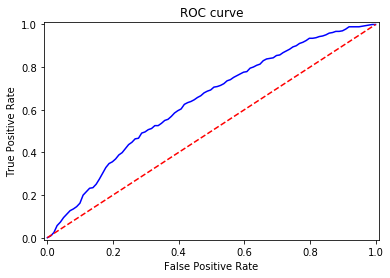

In [33]:
x_mean = s.measurements.outside.ThresholdRates.mean.fall_out
y_mean = s.measurements.outside.ThresholdRates.mean.recall

plt.plot(x_mean, y_mean, 'b')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')


Gain - ndcg at k=10

Browser agent's, device types, design choices and A/B all tests impact the manner in which listings are served. I chose k=10 because it strikes a reasonable balance covering the majority of impressions recieved and because on my current device (laptop) I see 10 listings without having to page. The manner in which different recommendations systems built from this data change relative to each other with varying k is another interesting area to explore in the future. 

In [34]:
def ndcg_score(sculpture, df=None, k=10):
    df = sculpture.outsideData.designData if df is None else df
    scores = sculpture.score(df)
    columns = [i for i in df if (i in ['Estimator', 'ds_search', 'id_user'] or i.startswith('query'))]
    df['relevance'] = df.label.map({'impression': 0, 'click': 1, 'host_contact': 3, 'book': 4})
    
    df = pd.concat([df[columns + ['relevance']] , scores], axis=1)
    gain = df.groupby(columns).apply(lambda sub: ndcg(sub.head(k)['relevance'].values,
                                                      sub.head(k)['Estimator'].values) if sub.relevance.sum() > 0 else None
                                     )
    return gain
    

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


0.799007610942


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c416790>]],
      dtype=object)

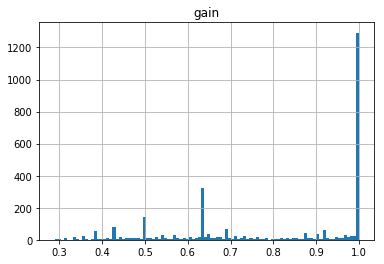

In [35]:
gains = ndcg_score(s)
print(gains.mean())
gains.rename('gain').to_frame().reset_index(drop=True).dropna().hist(bins=100)

### Feature Engineering
Feature engineering enables us to empower our model with a better semantic understanding of the relationships bewteen  the design and the target. Domain expertise and understanding of the contents of the available data is critical for feature engineering (call out to the not quite deterministic, to me, units of the `query_radius` field in this dataset). For this section I'll focus on two areas:

1) Improving imputations. In the baseline a flat mean was imputed, count fields should likely be zeroed (or in certain cases ceiled). Imputations don't pertain only to NULLs, the -1 in pricing bounds could imply no price bounds were set or the log was dropped.

2) Transforming existing data into a more useful form - this work can range from applying a non linear transform to a field to yield a better response from a glm to leveraging historical information to augment records

To start, I'll look at the data

#### NULLS

In [36]:
df.isnull().mean().loc[df.isnull().mean() > 0].sort_values().to_frame().rename(columns={0:'fraction_null'})

,fraction_null
listing_maximum_nights,0.001479
listing_minimum_nights,0.001479
listing_num_beds,0.050407
listing_num_bedrooms,0.050664
listing_property_type,0.050866
listing_total_price,0.051270
listing_num_bathrooms,0.051849
listing_has_pro_pictures,0.053043
listing_occupancy_rate,0.060850
listing_review_count,0.098720


Query data is flush, listing data could require some imputation work. The two `ds_` fields null column is a direct mapping of host contact and booking. We ignore these because we will not have them at request time (and in this case they would effectively leak the target itself into the design)

#### Missing value semantic assumptions

The percent of missing records associated with `_nights` is small we could drop, we could impute, the count is so low I would not expect it to be substantilly impactful unless the lack of existance correlates strongly with booking.


Next I'll look at the range of few fields to try to develop some intuition about how / why some values may be missing. The difference between that data was dropped from a log or not instrumented vs NULL being an actual description of an attribute (i.e. if a field can be 0 but never is 0, NULL may be implicity defined as 0, which would have negative impact on the models response if the mean was imputed).

In [37]:
df[['listing_num_bedrooms', 'listing_weekly_price_factor', 'listing_review_count', 'listing_cleaning_fee']].describe()

,listing_num_bedrooms,listing_weekly_price_factor,listing_review_count,listing_cleaning_fee
count,103358.000000,81342.000000,98126.000000,80939.000000
mean,1.480814,0.916827,22.172452,34.104293
std,1.154156,0.073984,37.661784,29.156729
min,0.000000,0.130000,0.000000,0.000000
25%,1.000000,0.890000,0.000000,18.542898
50%,1.000000,0.920000,5.000000,31.985073
75%,2.000000,0.980000,27.000000,42.383770
max,50.000000,1.000000,462.000000,799.626830


Given the ranges on these numbers, I will not dig further into imputations and instead focus on other transformations. To handle these records I'll create additional columns for the existance of a value in the field and then apply a min,max, or mean imputations applicably

In [38]:
df[[i for i in df if i.startswith('query_')]].head()

,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng
25,Sao Paulo,2018-11-27,2018-11-30,1,0,0,0.860144,-1.0,-1,-23.59,-46.68
26,Sao Paulo,2018-11-28,2018-11-30,1,0,0,0.479950,220.0,0,-23.59,-46.68
27,Sao Paulo,2018-11-27,2018-11-30,1,0,0,0.729681,140.0,0,-23.59,-46.68
28,Sao Paulo,2018-11-27,2018-11-30,1,0,0,0.860144,-1.0,-1,-23.59,-46.68
29,Sao Paulo,2018-11-28,2018-11-30,1,0,0,0.860144,-1.0,-1,-23.59,-46.68


Assuming price cannot be negative we'll assume `-1` in the query conveys no bound. While the existance of 0 and -1 in the min field potenitally refutes this in the future we can compare the impact of this transformation in isolation on our system performance. To transform this data I'll map -1 in max to the max of the column in the training set and -1 in the min to 0.

Location - with only two signifigant figures per degree in lat and long this data gives us slightly more information than the market field. What is relevant about these fields is the relation to what experiences / amenities lay in the area surrounding the target as well as the distance to listing. Evaluating the expected price for a listing given it's locaiton is an interesting and important area to look at in the future when other data sources can be integrated (public transit access, safety, amenity density / quality) we get some of that data from `listing_location_rating` but providing a collection values instead of a single scalar should benefit the model.

Date ranges - we can convert check in - checkout bounds into a length to convey the impact on length of the stay. (do longer stays, which cost more lead to longer searches that the user weighs more heavily?)

Distance - while distance calculations are negatively impacted by the number of signifigant digits in the lat/lon columns, I'll calculate a haversine distance in km between the query center and the listing locations. 


In [39]:
df.query_market.unique()

array(['Sao Paulo', 'Rio de Janeiro'], dtype=object)

#### Transforms



In [40]:
def udf_stateless(dataset):
    df = dataset.designData
    df['distance_km'] = df.apply(lambda x: haversine((x['query_center_lat'], x['query_center_lng']),
                                         (x['listing_lat'], x['listing_lng'])
                                         ), axis=1
                     ).round(0) #distance in km


    df['duration_days'] = (df.query_checkout.astype(int) - df.query_checkin.astype(int))\
                           / (1e9 * 3600 * 24) #nsec -> days
   
    df['amortized_costs'] = df.listing_total_price / (df.duration_days * df.query_num_guests)
    
    price_max = df['query_price_max']
    price_min = df['query_price_min']
    price_max = price_max.apply(lambda x: x if x>= 0 else pd.np.nan)
    price_min = price_min.apply(lambda x: x if x>= 0 else pd.np.nan)
    df['query_price_max'] = price_max
    df['query_price_min'] = price_min
    
    return dataset.with_params(X=df, y=dataset.targetData)

In [41]:
def load_model_full(model=LogisticRegression(C=.5), dropOne=True):

    graph = transformers.ModelDAG(set([]), {}, graphKwargs={'name': 'airbnb_recommendation'})

    n00 = transformers.Node('stateless', transformers.Apply(func=udf_stateless))
    
    n10 = transformers.Node('ohe', transformers.OneHotEncoder(dropOne=dropOne))
    
    # adds a boolean encoded column for each column with a fraction of nulls > tolerance
    # stores min/max from specified fields in training set and fills nulls in columns during transform
    n20 = transformers.Node('existance', transformer=transformers.Exists(tolerance=.2,
                                                                      minFields=['query_price_min'],
                                                                      maxFields=['query_price_max']))
    
    n21 = transformers.Node('mean_impute', transformer=transformers.Imputer(), enforceTarget=True)

    
    n22 = transformers.Node('scale', transformer=transformers.StandardScaler(), enforceTarget=True)

    n03 = transformers.Node('ml', transformer=model)

           
    
    graph.add_edge_flow(n00, n10, passTarget=False, selectValue=['listing_room_type','listing_has_pro_pictures'], invert=False)
    graph.add_edge_flow(n10, n03, passTarget=False)
    
    
    graph.add_edge_flow(n00, n20, selectValue={'include': ['number']}, selectMethod='data_type', invert=False)
    graph.add_edge_flow(n20, n21)    
    graph.add_edge_flow(n21, n22)    
    graph.add_edge_flow(n22, n03)

    return graph


In [44]:
logit = load_sculpture(df, outsideDf=validation_df, 
                       model=load_model_full(), 
                       validation='search', holdout=None, entire='search')

In [46]:
logit.fit()

Cross Validation
grid searching
grid searching
grid searching
grid searching
grid searching
Entire Dataset
grid searching


Sculpture_2019_05_28_08_21

In [47]:
logit.estimator.gridSearch.best_params_

{'model__ml__C': 10.0}

In [48]:
cat([helpers.view_sk_metric(logit.measurements.crossValidation.roc_auc_score),
    helpers.view_sk_metric(logit.measurements.outside.roc_auc_score)], ['validation', 'outside'])

,score_validation,score_outside
mean,0.657442,0.654058
std,0.015299,NaN


In [49]:
cat([helpers.view_sk_metric(logit.measurements.crossValidation.average_precision_score),
    helpers.view_sk_metric(logit.measurements.outside.average_precision_score)], ['validation', 'outside'])

,score_validation,score_outside
mean,0.021029,0.021257
std,0.001902,NaN


In [50]:
logit.measurements.outside.feature_weights.mean

,coefficients
names,
intercept_,-4.861454
distance_km,-3.987347
listing_lat,-3.059293
amortized_costs,-1.617258
listing_total_price,-0.667950
listing_room_type_Shared Room,-0.575123
listing_cleanliness_rating,-0.318860
query_price_max,-0.270403
listing_communication_rating,-0.238746


Two important area that I haven't looked at yet is nonlinear transform of the feature data to transfrom it into a linear space and the interactions between the features themselves. Rather than building these by hand I'll look to a non parametric model to give the same information with less effort to classify bookings. 


In [69]:
from sklearn.ensemble import RandomForestClassifier

rf = load_sculpture(df, outsideDf=validation_df, 
                   weights='feature_importances',
                   model=load_model_full(RandomForestClassifier(n_estimators=500, min_samples_split=250)), 
                   paramGrid={'model__ml__max_depth': range(6, 12, 2)}, 
                   entire='search', validation=False)

In [70]:
rf.fit()

Entire Dataset
grid searching


Sculpture_2019_05_28_16_59

In [71]:
rf.estimator.gridSearch.best_params_

{'model__ml__max_depth': 8}

In [72]:
helpers.view_sk_metric(rf.measurements.outside.roc_auc_score)

,score
mean,0.628002
std,NaN


In [74]:
helpers.view_sk_metric(rf.measurements.outside.average_precision_score)

,score
mean,0.019321
std,NaN


In [75]:
rf.measurements.outside.feature_weights.mean

,feature_importances
names,
listing_room_type_Shared Room,0.000887
listing_num_recent_reservations,0.000931
listing_weekly_discount,0.001039
listing_monthly_discount,0.001068
listing_weekly_price_factor_exists,0.001114
listing_room_type_Entire Home,0.001137
listing_has_pro_pictures_True,0.001138
query_price_min_exists,0.001167
listing_monthly_price_factor_exists,0.001215


While I could spend more time developing this model, given model performance and time constraints I'll move forward
with the logistic regression on the full transformation graph to test the performance on the validation set against the hold out set. 

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


0.8035700967257815

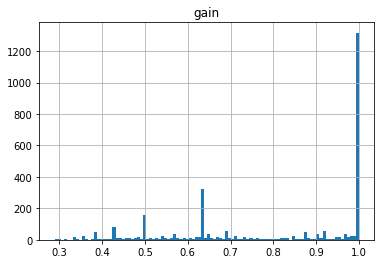

In [76]:
gains_validation = ndcg_score(logit)
gains_validation.rename('gain').to_frame().reset_index(drop=True).dropna().hist(bins=100)
gains_validation.mean()

In [77]:
gains = ndcg_score(logit, df=holdout_df)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


0.801363668521


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b390e10>]],
      dtype=object)

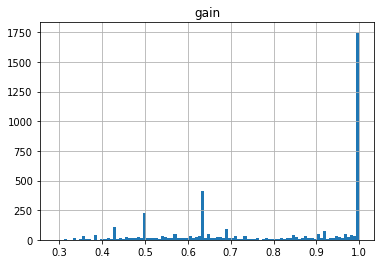

In [78]:
print(gains.mean())
gains.rename('gain').to_frame().reset_index(drop=True).dropna().hist(bins=100)

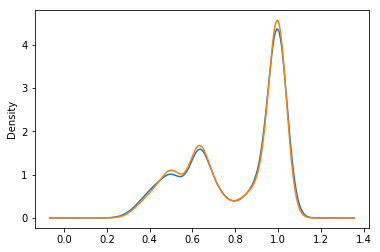

In [79]:
gains_validation.plot(kind='kde')
gains.plot(kind='kde')

In [80]:
from scipy.stats import ttest_ind
ttest_ind(gains.dropna().values, gains_validation.dropna().values, equal_var=False)

Ttest_indResult(statistic=-0.4238713631004248, pvalue=0.6716737145685947)

The gains associated with the validation and holdout sets are statistically similar!

### Model Development: future work

For the scoring component of the model, depending on the available data and infrastucture, I'd next look to a feed forward neural network after limited gains were made with Logistic Regression and the Random Forest. I've perturbed the hyperparameters and seen no substantial changes in scores (not shown fully) and I do not believe it would be worthwhile from a cost benefit perspective to spend resources finely grid searching the hyperparameter space for either of those two models.

More important to the model's ability to learn, and assuming a larger time window, developing more features about user preferences, via aggregations or personas through clustering could be a great next step. This work could be approached by classical clustering techniques as well as generating embeddings with auto-encoders in addition to identifying anomalies with isolation forests. While more nuanced than other two sided marketplaces because of uniqueness of supply and the phasing in and out of listings as available, one of the important areas not explored here yet is leveraging the suite of matrix factorization techniques to enable the model to share information between users. 

Last, our current framework suffers from a large (almost 1:100) class imbalance. Leveraging a synthetic technique like SMOTE (or even oversampling) to attempt to gain a better understanding of the dividing surface between bookings and not booking could be impactful.  

## New Listings: UX, dispersion, and ML scoring

One nice attribtue of 'clear' box models is we can see clearly why they made the decisions they made. Here we can see from our logit that having positive reviews, and simply having guests stay promotes booking. Not surprisingly, people prefer pre-vetted experiences. As a result, the scoring model promotes listing with strong reputations, an artifact of having had guests stay. New listings then suffer from having no reviews. 

If this system launched as is the long term health of AirBnB would be negatively affected because new listings would struggle to surface. This spiral phenomena would in turn impede the listings chance to surface in the future and of gaining reviews. Frustrated owners would stop listing or be discouraged from listing homes. 

A well designed ML system should augment and guide a product, not expect the product to follow it blindly (save the rare case where the system and the product are in fact 100% aligned). To acheive this our system needs to actively promote new listings. We can have a meta-model on our system that is trained to evaluate the bias against new listing through the viewing newness as the `treatment` and the model predicts that impact. We can then adjust the scores of the new listings upward by the predicted amount. If there's a strong incentive from AirBnB's perspective to promote new listings we can enforce additional policy such as one or more of the top-k is a new listing or 2x the treatment from the bias adjustment. All of these approaches would yield an effective decrease in the ndcg of the system but lead to a healthier marketplace. 

Dispersion is imperative in serving content. The manner in which listings are served can impact the trust a user has in the platform. In a hypothetical limiting case, consider an apartment building with several (say 20) nearly idential apartments. That apartment archetype's score is the most bookable for a user, but serving all 20 of those listing as the first 20 listings would not be a good user experience.

I've already talked about integrating with the existing search infrastructure so I'll conclude by mentioning an idea to leverage these scores in a completely different way. Typically search is thought as a stream from top to bottom, but being a web based application provides more interesting opportunity. This style of scoring system can help understand the value of "real estate" on the screen and the different techniques available to visually serve listings. Helping answer questions like where should the top ranked listing be placed on the screen as well as supporting other design choices not just with data, but with the ability to support inference on those techniques.

### Unused Transformers
These two transformers had negative impacts on model performance, but I think could merit further investigation 
with a larger window of time => larger volume of a user's history

In [81]:
class Pricepoint(transformers.DatasetTransformer):
    """
    Augment with difference of mean of amortized costs over user's cumalitve previous interactions
    and current listsings costs
    """
    @data.package_dataset
    @data.extract_fields
    def fit(self, X=None, y=None, dataset=None):
        df = dataset.designData
        collection = []
        interactions = df.loc[df.label != 'impression']

        for user, subset in interactions.groupby('id_user'):
            subset = subset.sort_values('ts_search')
            if len(subset):
                avg_cost_per_search = subset.groupby('ts_search').amortized_costs.mean().reset_index().sort_values(by='ts_search')
                avg_cost_per_search['prior_mean_avg_cost'] = avg_cost_per_search.amortized_costs.expanding().mean()
                avg_cost_per_search['id_user'] = user
                collection.append(avg_cost_per_search[['id_user', 'prior_mean_avg_cost', 'ts_search']])

        lookup = pd.concat(collection).sort_values('ts_search')
        lookup['ts_search'] = lookup.ts_search.astype(int)
        self.lookup = lookup.sort_values('ts_search')
        return self

    @data.extract_features
    @data.enforce_dataset
    def transform(self, X=None, y=None, dataset=None):
        df = dataset.designData
        df = df.sort_values('ts_search')
        df['ts_search'] = df.ts_search.astype(int)

        df_t = pd.merge_asof(df.reset_index(), self.lookup, on='ts_search', by='id_user',
                direction='backward', allow_exact_matches=False).set_index('index')

        df_t['prior_mean_avg_cost_delta'] = df_t.amortized_costs - df_t.prior_mean_avg_cost
        df_t = df_t.drop('prior_mean_avg_cost', axis=1)

        return dataset.with_params(X=df_t, y=dataset.targetData)


class DaysSearches(transformers.DatasetTransformer):
    """
    Count of user's searches executed previously that day
    """
    @data.package_dataset
    @data.extract_features
    @data.enforce_dataset
    def transform(self, X=None, y=None, dataset=None):
        df = dataset.designData
        collection = []
        interactions = df.loc[df.label != 'impression']

        for (user, day), subset in interactions.groupby(['id_user', 'ds_search']):
            subset = subset.drop_duplicates().sort_values('ts_search')
            if len(subset):
                num_searches = subset[['id_user', 'ts_search']]
                num_searches['prior_searches'] = subset.id_search.expanding().count()
                num_searches['id_user'] = user
                num_searches['id_user'] = user
                collection.append(num_searches)

        lookup = pd.concat(collection).sort_values('ts_search')
        lookup['ts_search'] = lookup.ts_search.astype(int)
        df = df.sort_values('ts_search')
        df['ts_search'] = df.ts_search.astype(int)

        df_t = pd.merge_asof(df.reset_index(), lookup, on='ts_search', by='id_user',
                direction='backward', allow_exact_matches=False).set_index('index')

        return dataset.with_params(X=df_t, y=dataset.targetData)
